# 4) 글로벌 전술적 자산 배분 전략 GTAA5

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [5]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [27]:
start = "2010"
end = "2022-10-31"

In [28]:
SPY = getCloseDataPandas("SPY",start, end) #1
EFA = getCloseDataPandas("EFA",start, end) #2
IEF = getCloseDataPandas("IEF",start, end) #3
DBC = getCloseDataPandas("DBC",start, end) #4
VNQ = getCloseDataPandas("VNQ",start, end)#5



closeDataSet = pd.concat([SPY, EFA,IEF,DBC,VNQ], axis=1)
closeDataSet.columns = ["SPY","EFA","IEF","DBC","VNQ"]
closeDataSet['cash'] =1
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,EFA,IEF,DBC,VNQ,cash
Date,,,,,,
2010-01-04,113.330002,56.730000,88.820000,25.240000,44.549999,1
2010-01-05,113.629997,56.779999,89.209999,25.270000,44.500000,1
2010-01-06,113.709999,57.020000,88.849998,25.719999,44.419998,1
2010-01-07,114.190002,56.799999,88.849998,25.400000,44.900002,1
2010-01-08,114.570000,57.250000,88.959999,25.379999,44.570000,1
...,...,...,...,...,...,...
2022-10-25,384.920013,59.279999,94.180000,25.090000,81.209999,1
2022-10-26,382.019989,59.840000,94.660004,25.559999,81.160004,1
2022-10-27,379.980011,59.279999,95.330002,25.600000,81.279999,1


In [29]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [30]:
weight = priceOnRebalDate.copy()
final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=closeDataSet.columns)


weight['mthavg_SPY'] = (weight['SPY'].shift(1)+weight['SPY'].shift(2)+weight['SPY'].shift(3)+weight['SPY'].shift(4)+weight['SPY'].shift(5)+weight['SPY'].shift(6)+weight['SPY'].shift(7)+weight['SPY'].shift(8)+weight['SPY'].shift(9)+weight['SPY'].shift(10))/10
weight['mthavg_EFA'] = (weight['EFA'].shift(1)+weight['EFA'].shift(2)+weight['EFA'].shift(3)+weight['EFA'].shift(4)+weight['EFA'].shift(5)+weight['EFA'].shift(6)+weight['EFA'].shift(7)+weight['EFA'].shift(8)+weight['EFA'].shift(9)+weight['EFA'].shift(10))/10
weight['mthavg_IEF'] = (weight['IEF'].shift(1)+weight['IEF'].shift(2)+weight['IEF'].shift(3)+weight['IEF'].shift(4)+weight['IEF'].shift(5)+weight['IEF'].shift(6)+weight['IEF'].shift(7)+weight['IEF'].shift(8)+weight['IEF'].shift(9)+weight['IEF'].shift(10))/10
weight['mthavg_DBC'] = (weight['DBC'].shift(1)+weight['DBC'].shift(2)+weight['DBC'].shift(3)+weight['DBC'].shift(4)+weight['DBC'].shift(5)+weight['DBC'].shift(6)+weight['DBC'].shift(7)+weight['DBC'].shift(8)+weight['DBC'].shift(9)+weight['DBC'].shift(10))/10
weight['mthavg_VNQ'] = (weight['VNQ'].shift(1)+weight['VNQ'].shift(2)+weight['VNQ'].shift(3)+weight['VNQ'].shift(4)+weight['VNQ'].shift(5)+weight['VNQ'].shift(6)+weight['VNQ'].shift(7)+weight['VNQ'].shift(8)+weight['VNQ'].shift(9)+weight['VNQ'].shift(10))/10

final_weight['SPY'] = np.where(weight['mthavg_SPY']>weight['SPY'] , 20,0)
final_weight['EFA'] = np.where(weight['mthavg_EFA']>weight['EFA'] , 20,0)
final_weight['IEF'] = np.where(weight['mthavg_IEF']>weight['IEF'] , 20,0)
final_weight['DBC'] = np.where(weight['mthavg_DBC']>weight['DBC'] , 20,0)
final_weight['VNQ'] = np.where(weight['mthavg_VNQ']>weight['VNQ'] , 20,0)


In [31]:
final_weight['cash'] = 100-(final_weight['SPY']+final_weight['EFA']+final_weight['IEF']+final_weight['DBC']+final_weight['VNQ'])

In [32]:
final_weight = final_weight *(1/100)

In [33]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 0.41695321704395516
cagr: 0.9336705296613286
mdd: 60.12009691982566


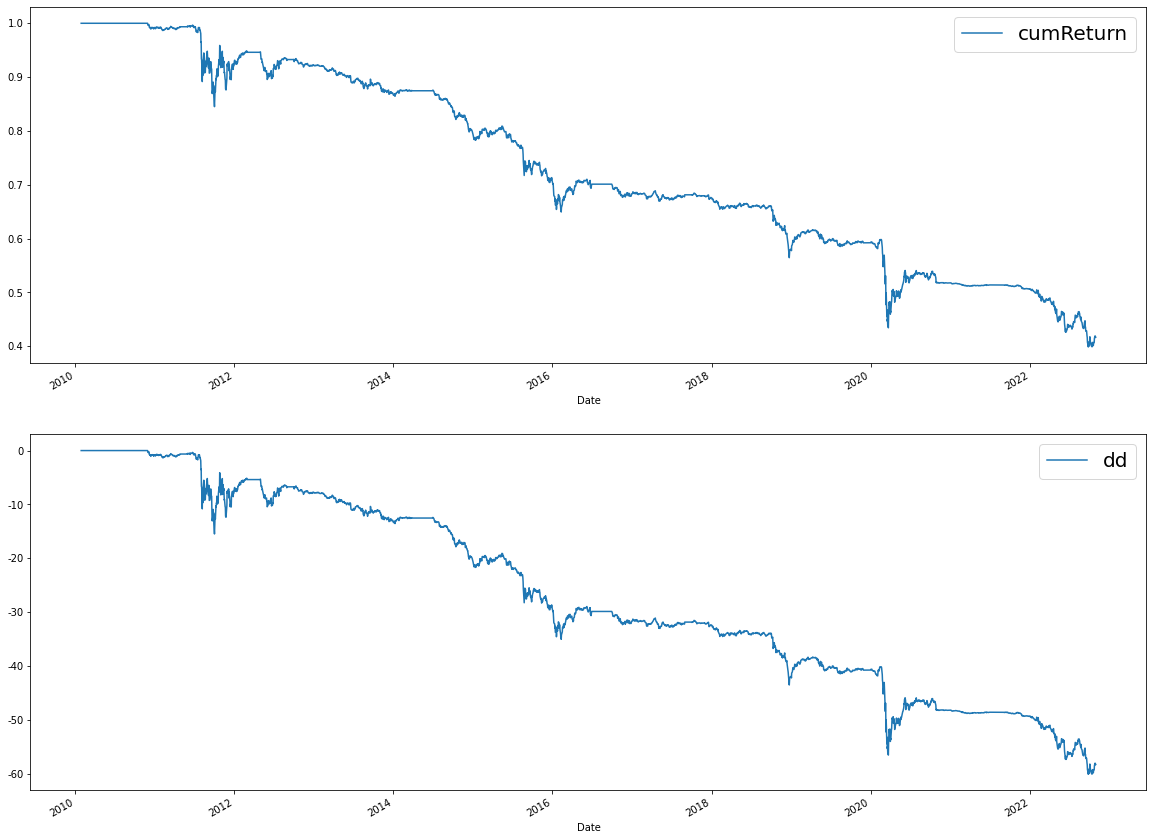

In [35]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="cumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()